In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [43]:
n = 100
context = data.init()
context, x_test, labels = data.import_data(context, n)

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Hat.mid
 [INFO] : 
 |  reading file: ../datasets/examples/02 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/114_LetsDance_DavidBowie1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/127_SweetChildOMine_GunsAndRoses1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/92_GiveItAway_TheRedHotChiliPeppers.mid
 [INFO] : 
 |  reading file: ../datasets/examples/94_Creep_Radiohead2.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 2.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 3.mid
 [INFO] : 
 |  reading file: ../datasets/exampl

In [6]:
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f)

# x_train = np.zeros([10,100,127])
y_train = x_train

WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.007291666666669
 |>  500
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.991666666666651
 |>  500
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.002083333333315
 |>  500
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.005208333333323
 |>  500
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.991666666666669
 |>  500
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.99166666666666
 |>  500
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.997916666666653
 |>  500
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNIN

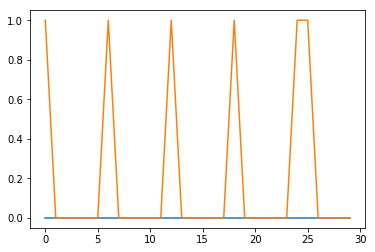

In [58]:
n6 = 30
plt.plot(x_train[0,:n6,0:])
# plt.plot(x_train[1,:n6,0:2])

In [59]:
# [sum(x) for x in x_train]
x_train.shape

(16, 500, 2)

In [60]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 10
x_train.shape

(16, 500, 2)

In [23]:
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
#     x = Dense(output_length * 2, activation='relu')(x)    
#     x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu')(x)
    x = Dense(output_length, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(output_length, activation='relu')(x)
#     x = Dense(output_length, activation='sigmoid')(x)
#     x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    #     model.add(Dropout(dropout))    
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    
    x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dropout(dropout)(x)
    x = Dropout(dropout)(x)
    x = Dense(np.prod(shape), activation='sigmoid')(x)
#     x = Dense(np.prod(shape), activation='sigmoid')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
#     x = UpSampling1D(10)(x)
    # make sure the conv layer increases the amount of dimensions
#     dims = keras.backend.int_shape(x)[1:]
#     n_steps = output_shape[0]
#     n_output_timesteps = output_shape[1]
#     filters = n_output_timesteps
#     conv_amt = 2
#     print('__+++==', n_output_timesteps)
#     x = Conv1D(filters, kernel_size=4, strides=2, activation='relu')(x) # 50,100

    dims = keras.backend.int_shape(x)[1:]
#     x = UpSampling1D(dims[0] * 2)(x)
#     x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model

dropout = 0.1
encoder, decoder, auto = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500, 2)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 10,120
Trainable params: 10,120
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_

In [24]:
metrics = ['accuracy','mse','mae']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adam'
auto.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
batch_size = 15
# n epochs = n iterations over all the training data
epochs = 150

In [26]:
m = 30
# xx = np.stack([x_train[0] for _ in range(m)])
# yy = xx
# history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = auto.fit(x_train[:m], y_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 25 samples, validate on 5 samples
Epoch 1/150
25/25 [==============================] - 0s 9ms/step - loss: 0.6933 - acc: 0.5078 - mean_squared_error: 0.2501 - mean_absolute_error: 0.4999 - val_loss: 0.6913 - val_acc: 0.5424 - val_mean_squared_error: 0.2491 - val_mean_absolute_error: 0.4990
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6886 - acc: 0.5922 - mean_squared_error: 0.2477 - mean_absolute_error: 0.4976 - val_loss: 0.6879 - val_acc: 0.5660 - val_mean_squared_error: 0.2474 - val_mean_absolute_error: 0.4970
Epoch 3/150
25/25 [==============================] - 0s 4ms/step - loss: 0.6813 - acc: 0.6216 - mean_squared_error: 0.2441 - mean_absolute_error: 0.4935 - val_loss: 0.6829 - val_acc: 0.5792 - val_mean_squared_error: 0.2449 - val_mean_absolute_error: 0.4934
Epoch 4/150
25/25 [==============================] - 0s 4ms/step - loss: 0.6703 - acc: 0.6384 - mean_squared_error: 0.2386 - mean_absolute_error: 0.4867 - val_loss: 0.6779 - val_acc: 0.5

Epoch 33/150
25/25 [==============================] - 0s 3ms/step - loss: 0.4530 - acc: 0.7676 - mean_squared_error: 0.1514 - mean_absolute_error: 0.3160 - val_loss: 0.6563 - val_acc: 0.6122 - val_mean_squared_error: 0.2301 - val_mean_absolute_error: 0.4153
Epoch 34/150
25/25 [==============================] - 0s 3ms/step - loss: 0.4378 - acc: 0.7753 - mean_squared_error: 0.1461 - mean_absolute_error: 0.3026 - val_loss: 0.6579 - val_acc: 0.6100 - val_mean_squared_error: 0.2309 - val_mean_absolute_error: 0.4158
Epoch 35/150
25/25 [==============================] - 0s 3ms/step - loss: 0.4398 - acc: 0.7752 - mean_squared_error: 0.1467 - mean_absolute_error: 0.3016 - val_loss: 0.6583 - val_acc: 0.6098 - val_mean_squared_error: 0.2309 - val_mean_absolute_error: 0.4145
Epoch 36/150
25/25 [==============================] - 0s 3ms/step - loss: 0.4454 - acc: 0.7772 - mean_squared_error: 0.1488 - mean_absolute_error: 0.3079 - val_loss: 0.6643 - val_acc: 0.6156 - val_mean_squared_error: 0.2319 - 

Epoch 65/150
25/25 [==============================] - 0s 4ms/step - loss: 0.3475 - acc: 0.8276 - mean_squared_error: 0.1135 - mean_absolute_error: 0.2412 - val_loss: 0.7162 - val_acc: 0.6134 - val_mean_squared_error: 0.2449 - val_mean_absolute_error: 0.4101
Epoch 66/150
25/25 [==============================] - 0s 5ms/step - loss: 0.3002 - acc: 0.8605 - mean_squared_error: 0.0957 - mean_absolute_error: 0.2136 - val_loss: 0.7162 - val_acc: 0.6122 - val_mean_squared_error: 0.2452 - val_mean_absolute_error: 0.4105
Epoch 67/150
25/25 [==============================] - 0s 4ms/step - loss: 0.3180 - acc: 0.8481 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2231 - val_loss: 0.7213 - val_acc: 0.6104 - val_mean_squared_error: 0.2469 - val_mean_absolute_error: 0.4113
Epoch 68/150
25/25 [==============================] - 0s 5ms/step - loss: 0.3452 - acc: 0.8371 - mean_squared_error: 0.1111 - mean_absolute_error: 0.2406 - val_loss: 0.7260 - val_acc: 0.6116 - val_mean_squared_error: 0.2486 - 

Epoch 97/150
25/25 [==============================] - 0s 3ms/step - loss: 0.3071 - acc: 0.8546 - mean_squared_error: 0.0994 - mean_absolute_error: 0.2010 - val_loss: 0.8548 - val_acc: 0.5974 - val_mean_squared_error: 0.2749 - val_mean_absolute_error: 0.4152
Epoch 98/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2356 - acc: 0.9002 - mean_squared_error: 0.0720 - mean_absolute_error: 0.1710 - val_loss: 0.8354 - val_acc: 0.5968 - val_mean_squared_error: 0.2722 - val_mean_absolute_error: 0.4155
Epoch 99/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2544 - acc: 0.8908 - mean_squared_error: 0.0790 - mean_absolute_error: 0.1750 - val_loss: 0.8121 - val_acc: 0.6010 - val_mean_squared_error: 0.2676 - val_mean_absolute_error: 0.4137
Epoch 100/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2279 - acc: 0.9067 - mean_squared_error: 0.0692 - mean_absolute_error: 0.1653 - val_loss: 0.7983 - val_acc: 0.6044 - val_mean_squared_error: 0.2641 -

Epoch 129/150
25/25 [==============================] - 0s 3ms/step - loss: 0.1623 - acc: 0.9448 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1095 - val_loss: 0.9136 - val_acc: 0.5996 - val_mean_squared_error: 0.2835 - val_mean_absolute_error: 0.4120
Epoch 130/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2250 - acc: 0.9009 - mean_squared_error: 0.0697 - mean_absolute_error: 0.1492 - val_loss: 0.9152 - val_acc: 0.5986 - val_mean_squared_error: 0.2832 - val_mean_absolute_error: 0.4115
Epoch 131/150
25/25 [==============================] - 0s 3ms/step - loss: 0.1848 - acc: 0.9260 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1267 - val_loss: 0.9145 - val_acc: 0.6002 - val_mean_squared_error: 0.2824 - val_mean_absolute_error: 0.4106
Epoch 132/150
25/25 [==============================] - 0s 2ms/step - loss: 0.1828 - acc: 0.9227 - mean_squared_error: 0.0543 - mean_absolute_error: 0.1290 - val_loss: 0.9162 - val_acc: 0.6094 - val_mean_squared_error: 0.281

(0, 1.025344226360321)

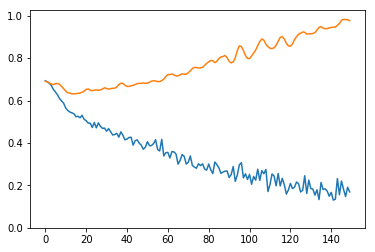

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(ymin=0)

(0, 1)

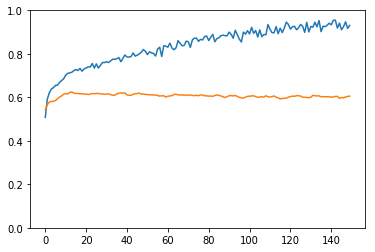

In [62]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(ymin=0, ymax=1)

In [63]:
results = auto.predict(x_train[:10])
results.shape

(10, 500, 2)

(0, 1)

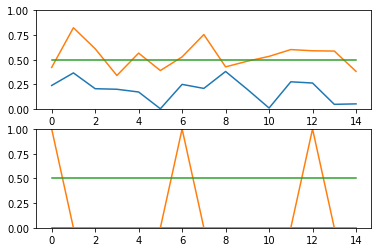

In [64]:
n1 = 15
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

plt.subplot(212)
plt.plot(np.arange(n1), x_train[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

(0, 1)

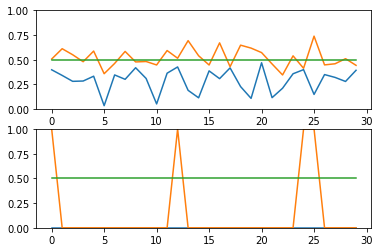

In [65]:
n1 = 30
i = 1
plt.subplot(211)
plt.plot(np.arange(n1), results[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [70]:
mid_true = midi.decode_track(context, x_train[0])
mid_pred = midi.decode_track(context, results[0])
dn = config.export_dir
io.export_midifile(mid_true, dn + 'mid_true.mid')
io.export_midifile(mid_pred, dn + 'mid_pred.mid')

 [INFO] : 
 |  len, max_t
 |  7.910416666666669
 |  10.0
 [INFO] : 
 |  len, max_t
 |  10.114583333333293
 |  10.0


In [68]:
mid_pred

<midi file None type 1, 1 tracks, 584 messages>

In [69]:
mid_true

<midi file None type 1, 1 tracks, 132 messages>

# Test with 'real' data

The model does not perform well on new data

In [46]:
x_test.shape

(16, 500, 2)

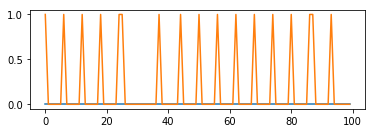

In [51]:
plt.subplot(211)
plt.plot(x_test[0,:100,:])

In [52]:
y_test = auto.predict(x_test[:])
y_test.shape

(16, 500, 2)

(0, 1)

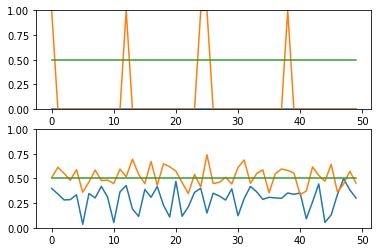

In [54]:
n1 = 50
i = 1
plt.subplot(211)
plt.plot(np.arange(n1), x_test[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), y_test[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [55]:
mid_true = midi.decode_track(context, x_test[0])
mid_pred = midi.decode_track(context, y_test[0])
dn = config.export_dir
io.export_midifile(mid_true, dn + 'real_mid_true.mid')
io.export_midifile(mid_pred, dn + 'real_mid_pred.mid')

 [INFO] : 
 |  len, max_t
 |  7.910416666666669
 |  10.0
 [INFO] : 
 |  len, max_t
 |  10.114583333333293
 |  10.0
